## Import libraries

In [28]:
import torch
import os
from torchvision import transforms, datasets
from torchvision.datasets import VisionDataset
from torch.utils.data import DataLoader, ConcatDataset

from collections import Counter
import matplotlib.pyplot as plt

from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, ViTForImageClassification,TrainingArguments
import numpy as np


import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing and augumentation

In [29]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
image_mean, image_std = processor.image_mean, processor.image_std

# Define Transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #Data augumentation to vary images, to avoid overfitting problems
    transforms.RandomRotation(20),
    transforms.Normalize(mean=image_mean, std=image_std)  # Normalize images
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])


# Load Dataset
train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='chest_xray/test', transform=test_transform)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Class 0: 1341
Class 1: 3875


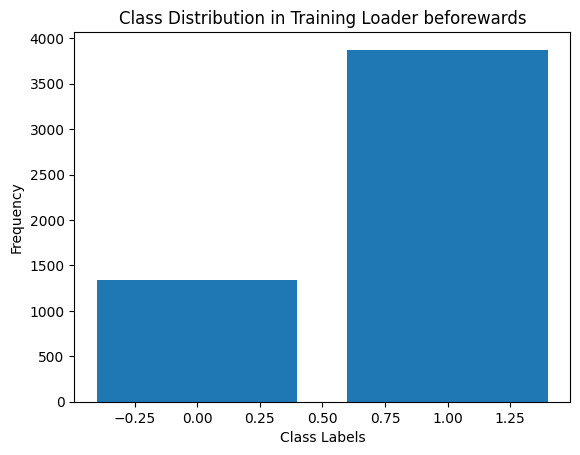

In [30]:
# Count the occurrences of each class in the train loader
class_counts = Counter()

# Since we use a sampler, the DataLoader will yield samples according to the weights
for _, labels in train_loader:
    class_counts.update(labels.numpy())

# Convert to a sorted list for consistent ordering
class_labels, class_freqs = zip(*sorted(class_counts.items()))

# Print the class distribution
for label, freq in zip(class_labels, class_freqs):
    print(f'Class {label}: {freq}')

# Optionally, visualize the class distribution
plt.bar(class_labels, class_freqs)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Loader beforewards')
plt.show()

In [31]:
# Balance the dataset to make normal and pneumonia sample counts almost equal. 
# Because the ratio between normal and pneumonia counts is 1:3, I augment the normal train dataset twice
class CustomDataset(VisionDataset):
    def __init__(self, samples, transform=None):
        super().__init__("", transform=transform)
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Separate the datasets
normal_dataset = [sample for sample in train_dataset.samples if sample[1] == 0]  # Filter normal samples

normal_samples = [(path, 0) for path, _ in normal_dataset]

# Augment the normal dataset
# Create ImageFolder instances for augmented normal samples
normal_dataset = CustomDataset(normal_samples, transform=train_transform)

# Concatenate the datasets
balanced_train_dataset = ConcatDataset([train_dataset, normal_dataset, normal_dataset])

# DataLoaders
train_loader = DataLoader(balanced_train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Class 0: 4023
Class 1: 3875


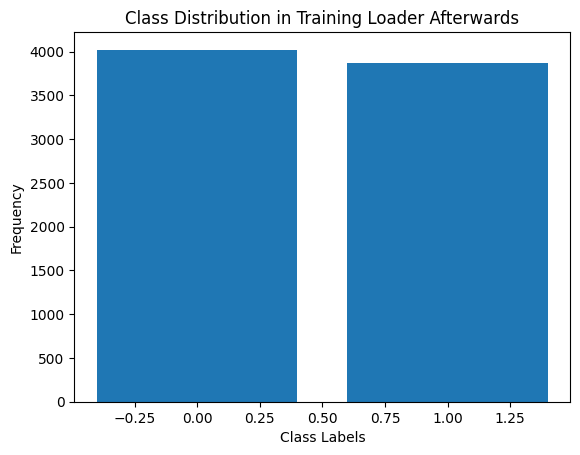

In [32]:
# Count the occurrences of each class in the train loader
class_counts = Counter()

# Since we use a sampler, the DataLoader will yield samples according to the weights
for _, labels in train_loader:
    class_counts.update(labels.numpy())

# Convert to a sorted list for consistent ordering
class_labels, class_freqs = zip(*sorted(class_counts.items()))

# Print the class distribution
for label, freq in zip(class_labels, class_freqs):
    print(f'Class {label}: {freq}')

# Optionally, visualize the class distribution
plt.bar(class_labels, class_freqs)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Loader Afterwards')
plt.show()

In [33]:
print(len(train_dataset))
print(len(balanced_train_dataset))
print(len(test_dataset))

5216
7898
640


In [34]:
torch.manual_seed(0)

In [35]:
print(torch.cuda.is_available()) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [36]:
class_names = train_dataset.classes
print(class_names)
print(train_dataset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


## Load model
I used a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels (2). VITForImageClassification is one type of VIT ((vision transform)) model, which is pretrained on ImageNet-21k ((14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224).

https://huggingface.co/docs/transformers/en/model_doc/vit\
https://huggingface.co/google/vit-base-patch16-224

In [37]:
# Load model directly
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [39]:
!pip install evaluate

## Training and validation

In [40]:
import evaluate

metric = evaluate.load("accuracy")
model_name = "chest-xray-classification"

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example[0] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example[1] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

num_train_epochs = 3

args = TrainingArguments(
    output_dir = model_name,
    logging_dir='./logs',
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,# Apply weight decay to prevent overfitting.
    warmup_steps=50,    # Set the number of warm-up steps for the learning rate scheduler.
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,  # Load the best model at the end of training.
    
)

trainer = Trainer(
    model,
    args,
    train_dataset=balanced_train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

In [41]:
#Fine tuning
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.209665,0.928125
2,0.130500,0.463210,0.887500
3,0.047500,0.309084,0.923438


TrainOutput(global_step=1482, training_loss=0.06947267264650579, metrics={'train_runtime': 1017.5127, 'train_samples_per_second': 23.286, 'train_steps_per_second': 1.456, 'total_flos': 1.8360952019281428e+18, 'train_loss': 0.06947267264650579, 'epoch': 3.0})

In [42]:
trainer.evaluate()

{'eval_loss': 0.20966458320617676,
 'eval_accuracy': 0.928125,
 'eval_runtime': 15.2735,
 'eval_samples_per_second': 41.903,
 'eval_steps_per_second': 5.238,
 'epoch': 3.0}

In [43]:
outputs = trainer.predict(test_dataset)
print(outputs.metrics)

{'test_loss': 0.20966458320617676, 'test_accuracy': 0.928125, 'test_runtime': 15.0085, 'test_samples_per_second': 42.642, 'test_steps_per_second': 5.33}


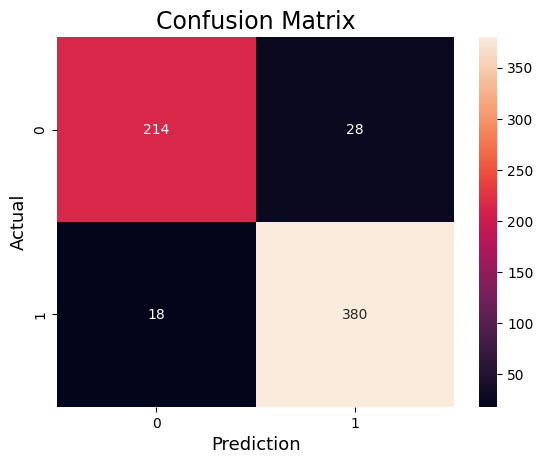

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       242
           1       0.93      0.95      0.94       398

    accuracy                           0.93       640
   macro avg       0.93      0.92      0.92       640
weighted avg       0.93      0.93      0.93       640



In [44]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
cr = classification_report(y_true, y_pred)
print(cr)

## Save the model

In [55]:
!rm -rf /kaggle/working/*

In [56]:
trainer.save_model() #save the entire pretrained model for future use, so that do not need to train it again

In [57]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/chest-xray-classification/ (stored 0%)
  adding: kaggle/working/chest-xray-classification/config.json (deflated 46%)
  adding: kaggle/working/chest-xray-classification/training_args.bin (deflated 51%)
  adding: kaggle/working/chest-xray-classification/model.safetensors (deflated 7%)
  adding: kaggle/working/chest-xray-classification/preprocessor_config.json (deflated 58%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)


In [58]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [59]:
from transformers import pipeline

pipe = pipeline('image-classification', model=model_name, device=0)

In [60]:
# Test normal dataset
img_normal = "/kaggle/input/chest-xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg"
pipe(img_normal)

[{'label': 'LABEL_0', 'score': 0.9885502457618713},
 {'label': 'LABEL_1', 'score': 0.011449712328612804}]

In [61]:
# Test pneumonia dataset
img_bacteria = "/kaggle/input/chest-xray/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg"
pipe(img_bacteria)

[{'label': 'LABEL_1', 'score': 0.998590886592865},
 {'label': 'LABEL_0', 'score': 0.0014091396005824208}]

In [ ]:
# !pip install torchcam

In [ ]:
# from torchvision.io.image import read_image
# from torchvision.transforms.functional import normalize, resize, to_pil_image,to_tensor
# from torchvision.models import resnet18
# from torchcam.methods import CAM, SmoothGradCAMpp
# from PIL import Image
# import matplotlib.pyplot as plt
# from torchcam.utils import overlay_mask


# def activationMap(image):
#     img = Image.open(image)
#     img = img.convert("RGB")
#     img = img.resize((224,224))
#     img_tensor = to_tensor(img)

#     # Preprocess it for your chosen model
#     input_tensor = normalize(img_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)
#     out = model(input_tensor.unsqueeze(0))[0]
    
#     cam_extract = CAM(model)
    
#   # Preprocess your data and feed it to the model

#   # Retrieve the CAM by passing the class index and the model output
#     activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
        
#     plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
#     # Resize the CAM and overlay it
#     result = overlay_mask(to_pil_image(input_tensor), to_pil_image(activation_map[0].squeeze(0).cpu(), mode='F'), alpha=0.5)
#     # Display it
#     plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
# # # Normal
# activationMap("/kaggle/input/chest-xray/chest_xray/test/NORMAL/IM-0003-0001.jpeg")

In [ ]:
# # Pneumonia/bacteria
# activationMap("/kaggle/input/chest-xray-balanced/chest_xray_balanced/test/PNEUMONIA/person109_bacteria_517.jpeg")

In [ ]:
# # Pneumonia/virus
# activationMap("/kaggle/input/chest-xray-balanced/chest_xray_balanced/test/PNEUMONIA/person10_virus_35.jpeg")